In [48]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

Loading both parquetfiles

In [49]:
file_path_weather = r'C:\Users\200408\OneDrive - Betonmast\Skrivebord\NTNU\Prosjektoppgave\Klimadata\output_file.parquet'
file_path_sensor = r'C:\Users\200408\OneDrive - Betonmast\Skrivebord\NTNU\Prosjektoppgave\Averages\average_per_hour_new.parquet'


# Read the Parquet files into Pandas DataFrames
weather_data = pd.read_parquet(file_path_weather)
sensor_data = pd.read_parquet(file_path_sensor)

# Remove the 'group_num' column from sensor_data DataFrame
sensor_data = sensor_data.drop('group_num', axis=1)
# Rename the column
sensor_data = sensor_data.rename(columns={'Days_since_2019.12.31': 'Hours_since_2019.12.31'})


# Display the contents of the DataFrames
print("Weather Data:")
print(weather_data.head())  # Display the first few rows

print("\nSensor Data:")
print(sensor_data.head())  # Display the first few rows


Weather Data:
  Tid(norsk normaltid)  Gjennomsnittlig globalstråling (1 t)  \
0           2020090101                                   0.0   
1           2020090102                                   0.0   
2           2020090103                                   0.0   
3           2020090104                                   0.0   
4           2020090105                                   1.1   

   Solskinnstid (1 t)  Middel av middelvind (1 t)  Nedbør (1 t)  \
0                 0.0                         1.9           0.0   
1                 0.0                         1.4           0.0   
2                 0.0                         0.6           0.0   
3                 0.0                         0.6           0.0   
4                 0.0                         1.1           0.0   

   Relativ luftfuktighet  
0                   67.0  
1                   71.0  
2                   74.0  
3                   73.0  
4                   68.0  

Sensor Data:
   Hours_since_2019.12

In [45]:
# Slice the "Date" column to keep only the first 10 characters
sensor_data['Date'] = sensor_data['Date'].astype(str).str.slice(0, 10)


# Display the contents of the DataFrames
print("Weather Data:")
print(weather_data.head())  # Display the first few rows

# Display the modified DataFrame
print("Sensor Data:")
print(sensor_data.head())  # Display the first few rows

Weather Data:
  Tid(norsk normaltid)  Gjennomsnittlig globalstråling (1 t)  \
0           2020090101                                   0.0   
1           2020090102                                   0.0   
2           2020090103                                   0.0   
3           2020090104                                   0.0   
4           2020090105                                   1.1   

   Solskinnstid (1 t)  Middel av middelvind (1 t)  Nedbør (1 t)  \
0                 0.0                         1.9           0.0   
1                 0.0                         1.4           0.0   
2                 0.0                         0.6           0.0   
3                 0.0                         0.6           0.0   
4                 0.0                         1.1           0.0   

   Relativ luftfuktighet  
0                   67.0  
1                   71.0  
2                   74.0  
3                   73.0  
4                   68.0  
Sensor Data:
   Hours_since_2019.12.

Combine the weater and sensor data

In [46]:
# Renaming the column to remove hidden characters such as BOM
weather_data.columns = [col.replace('\ufeff', '') for col in weather_data.columns]

# Now ensure both key columns are of the same type (string) for a proper merge.
sensor_data['Date'] = sensor_data['Date'].astype(str)
weather_data['Tid(norsk normaltid)'] = weather_data['Tid(norsk normaltid)'].astype(str)

# Merge the DataFrames on the date/time columns.
combined_data = pd.merge(sensor_data, weather_data, left_on='Date', right_on='Tid(norsk normaltid)', how='inner')

combined_data = combined_data.drop('Tid(norsk normaltid)', axis=1)

# Translations from Norwegian to English
column_name_translations = {
    'Hours_since_2019.12.31': 'Hours_since_2019.12.31',
    'Date': 'Date',
    'Point_1_N_mean': 'Point_1_N_mean',
    'Point_2_N_mean': 'Point_2_N_mean',
    'Point_3_N_mean': 'Point_3_N_mean',
    'Point_4_S_mean': 'Point_4_S_mean',
    'Point_5_S_mean': 'Point_5_S_mean',
    'Point_6_S_mean': 'Point_6_S_mean',
    'Omega_N_mean': 'Omega_N_mean',
    'Omega_S_mean': 'Omega_S_mean',
    'PT100_Temperature_mean': 'PT100_Temperature_mean',
    'Gjennomsnittlig globalstråling (1 t)': 'Average_Global_Radiation_(1h)',
    'Solskinnstid (1 t)': 'Sunshine_Duration_(1h)',
    'Middel av middelvind (1 t)': 'Average_of_Mean_Wind_(1h)',
    'Nedbør (1 t)': 'Precipitation_(1h)',
    'Relativ luftfuktighet': 'Relative_Humidity(1h)'
}

# Rename the columns
combined_data.rename(columns=column_name_translations, inplace=True)

# Display the head of the combined DataFrame
print(combined_data)

       Hours_since_2019.12.31        Date  Point_1_N_mean  Point_2_N_mean  \
0                        5916  2020090212       18.324186       16.439996   
1                        5940  2020090312       24.667922       24.155004   
2                        5962  2020090410      -15.535099      -21.302234   
3                        5966  2020090414      -10.819921      -15.643464   
4                        5970  2020090418      -15.399971      -18.856000   
...                       ...         ...             ...             ...   
26807                   35082  2023123118      -20.227229     -104.882947   
26808                   35083  2023123119      -19.488729     -105.022363   
26809                   35084  2023123120      -21.503484     -107.888565   
26810                   35085  2023123121      -22.667015     -109.260424   
26811                   35086  2023123122      -22.800138     -110.541549   

       Point_3_N_mean  Point_4_S_mean  Point_5_S_mean  Point_6_S_mean  \
0 

Create a parquetfile

In [47]:
# Convert the pandas DataFrame to a PyArrow Table
table = pa.Table.from_pandas(combined_data)

# Specify the file path and name for the Parquet file
parquet_file_path = r'C:\Users\200408\OneDrive - Betonmast\Skrivebord\NTNU\Prosjektoppgave\Averages\combined_english.parquet'

# Write the Table to a Parquet file
pq.write_table(table, parquet_file_path)

print(f"DataFrame has been saved as a Parquet file at {parquet_file_path}")


DataFrame has been saved as a Parquet file at C:\Users\200408\OneDrive - Betonmast\Skrivebord\NTNU\Prosjektoppgave\Averages\combined_english.parquet


   Hours_since_2019.12.31        Date  Point_1_N_mean  Point_2_N_mean  \
0                    5916  2020090212       18.324186       16.439996   
1                    5940  2020090312       24.667922       24.155004   
2                    5962  2020090410      -15.535099      -21.302234   
3                    5966  2020090414      -10.819921      -15.643464   
4                    5970  2020090418      -15.399971      -18.856000   

   Point_3_N_mean  Point_4_S_mean  Point_5_S_mean  Point_6_S_mean  \
0       12.273690       43.943916       41.496791       32.350760   
1       18.399311       58.603003       57.104418       46.496854   
2      -17.400303       43.134141       39.866109       29.849380   
3      -12.470669       51.753103       50.788288       37.997157   
4      -14.976123       52.673533       51.309598       36.255848   

   Omega_N_mean  Omega_S_mean  PT100_Temperature_mean  \
0     -0.000391     -0.002391               16.261441   
1     -0.000950      0.001639   

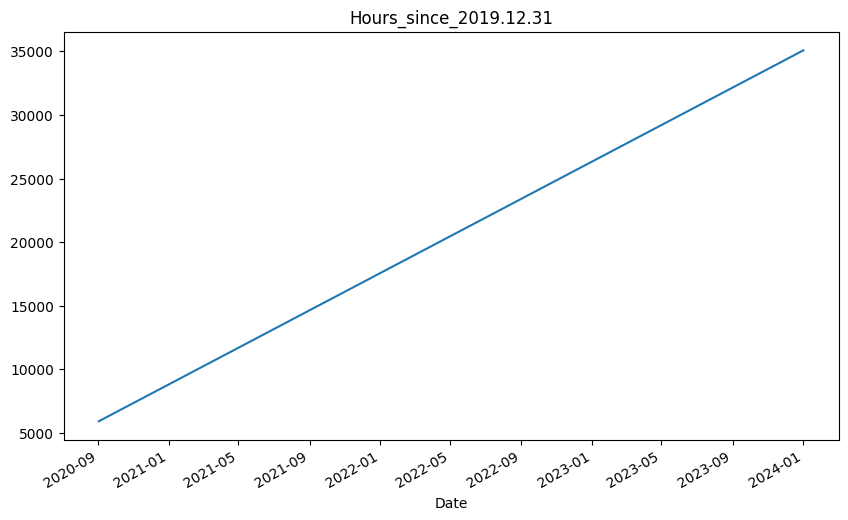

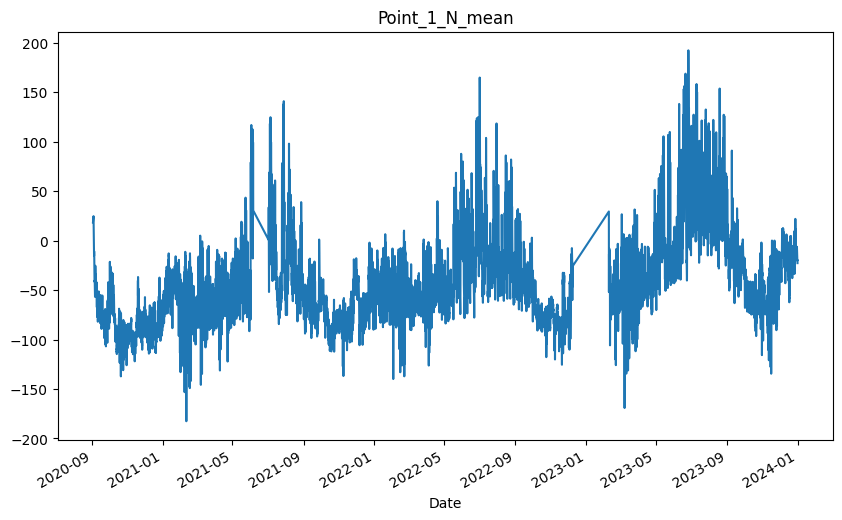

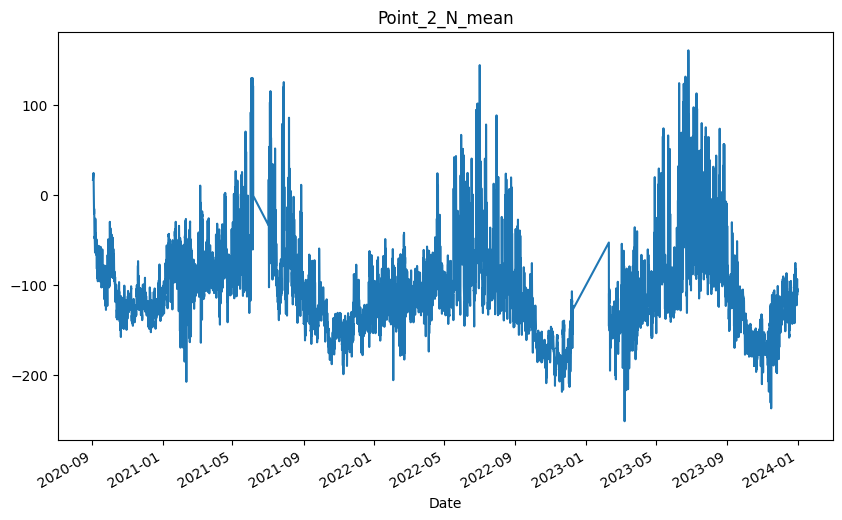

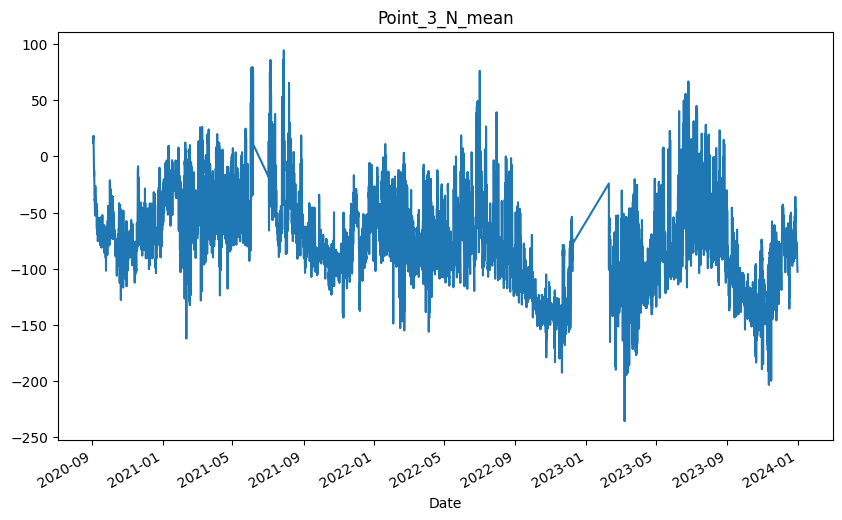

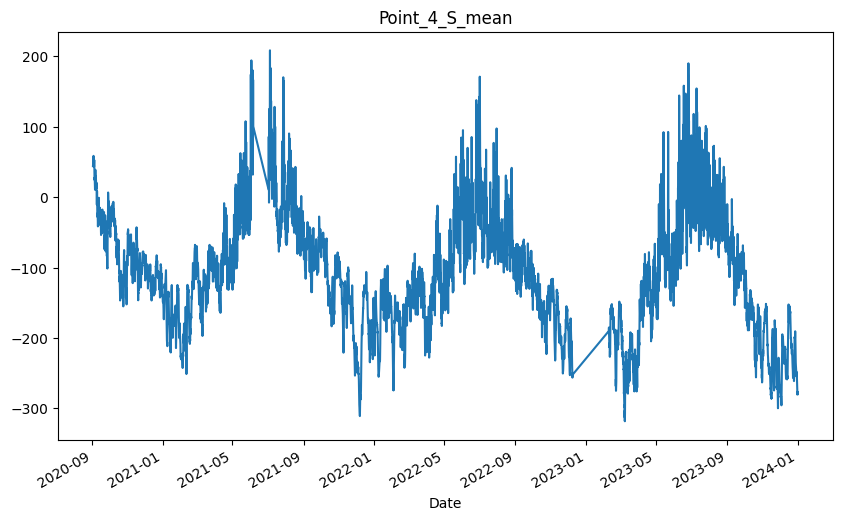

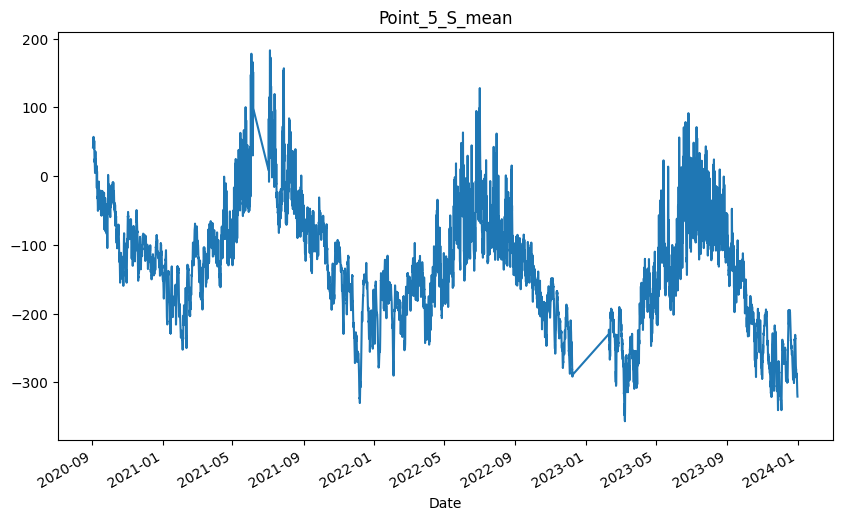

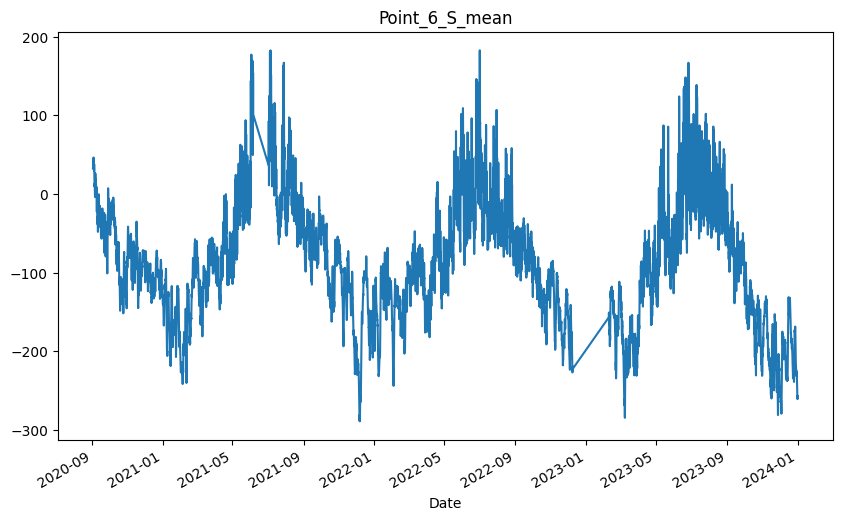

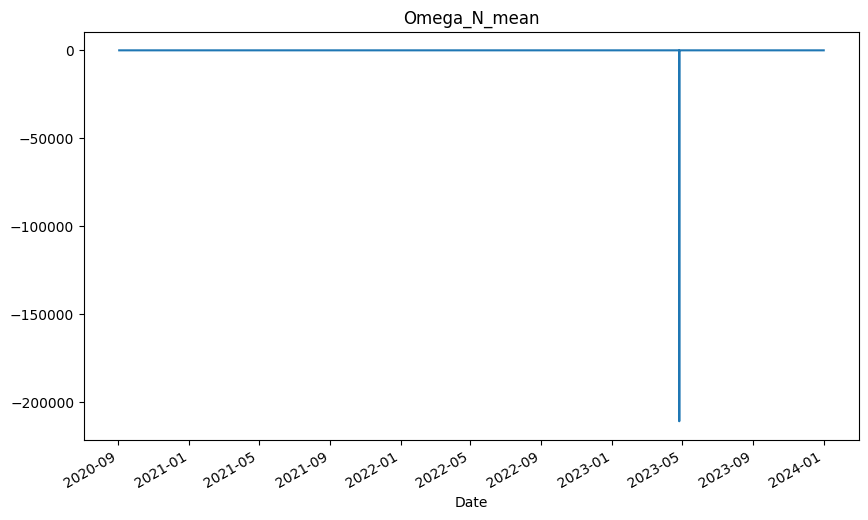

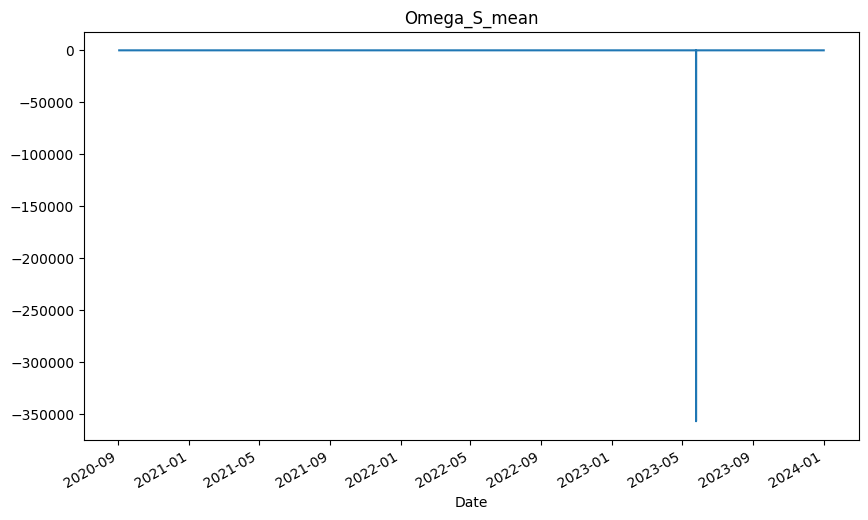

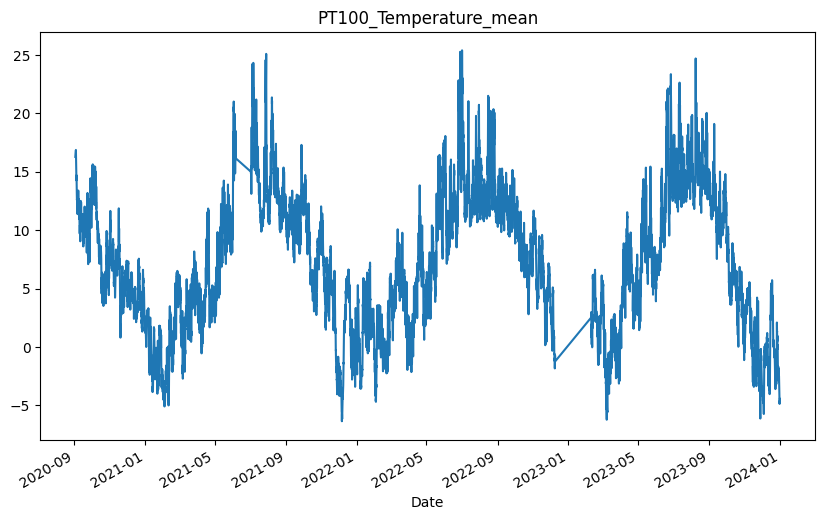

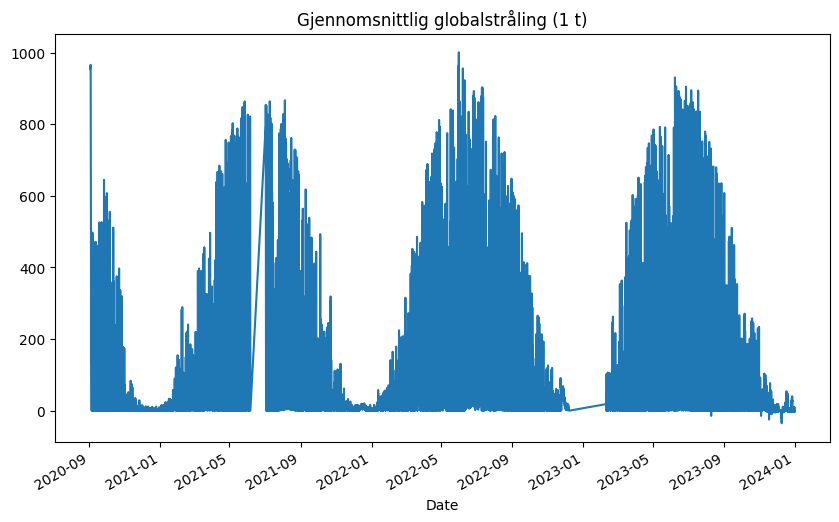

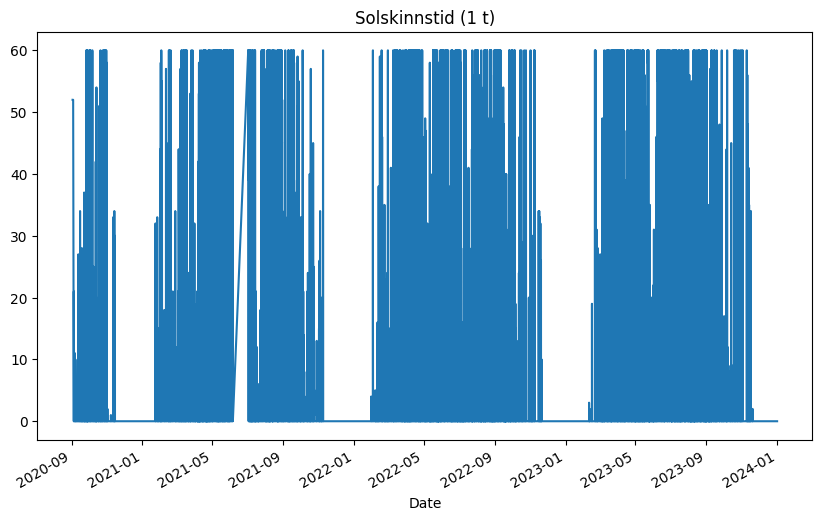

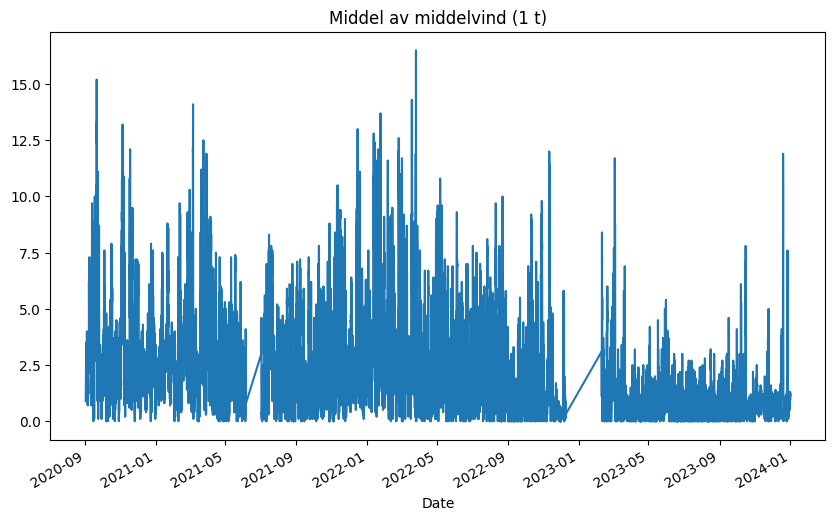

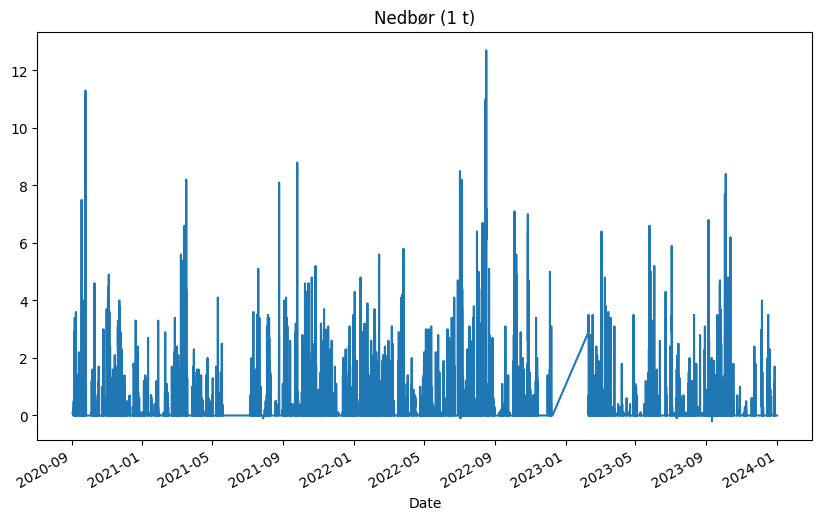

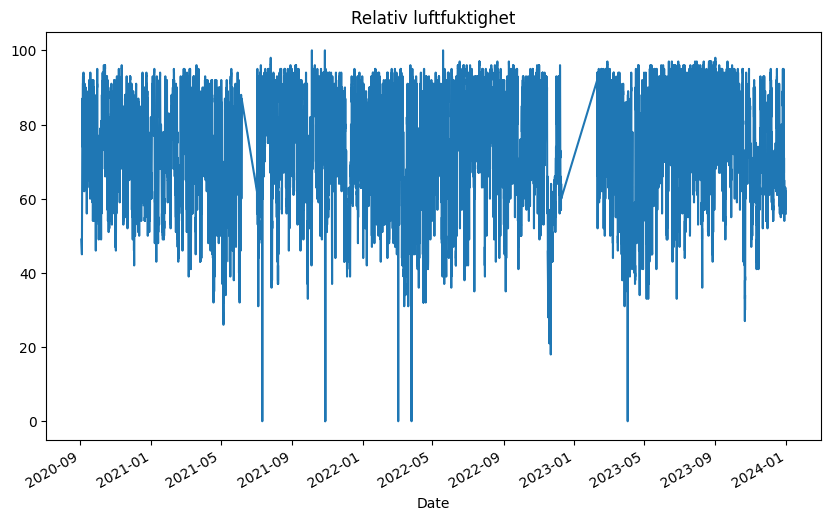

In [34]:
# Replace this with the path to your Parquet file
file_path = r'C:\Users\200408\OneDrive - Betonmast\Skrivebord\NTNU\Prosjektoppgave\Averages\combined.parquet'

# Read the Parquet file into a Pandas DataFrame
data = pd.read_parquet(file_path)


print(data.head())

# Convert 'Date' column to datetime object
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d%H')

# Set 'Date' column as the index
data.set_index('Date', inplace=True)

# Loop through each column
for column in data.columns:
    # Create a new figure
    plt.figure(figsize=(10,6))
    # Plot the column
    data[column].plot()
    # Add a title
    plt.title(column)
    # Show the plot
    plt.show()